In [75]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [76]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# Import OpenCV
import cv2
from os import listdir
from os.path import isfile, join 

In [77]:
subsets = ['train','valid','test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']


In [78]:
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Mun/Spring2020/Course_Study/9804 (ImageProcessingandApplications)/Project/Code/data')

In [79]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [80]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Mun\Spring2020\Course_Study\9804 (ImageProcessingandApplications)\Project\Code\data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Mun\Spring2020\Course_Study\9804 (ImageProcessingandApplications)\Project\Code\data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Mun\Spring2020\Course_Study\9804 (ImageProcessingandApplications)\Project\Code\data

In [81]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


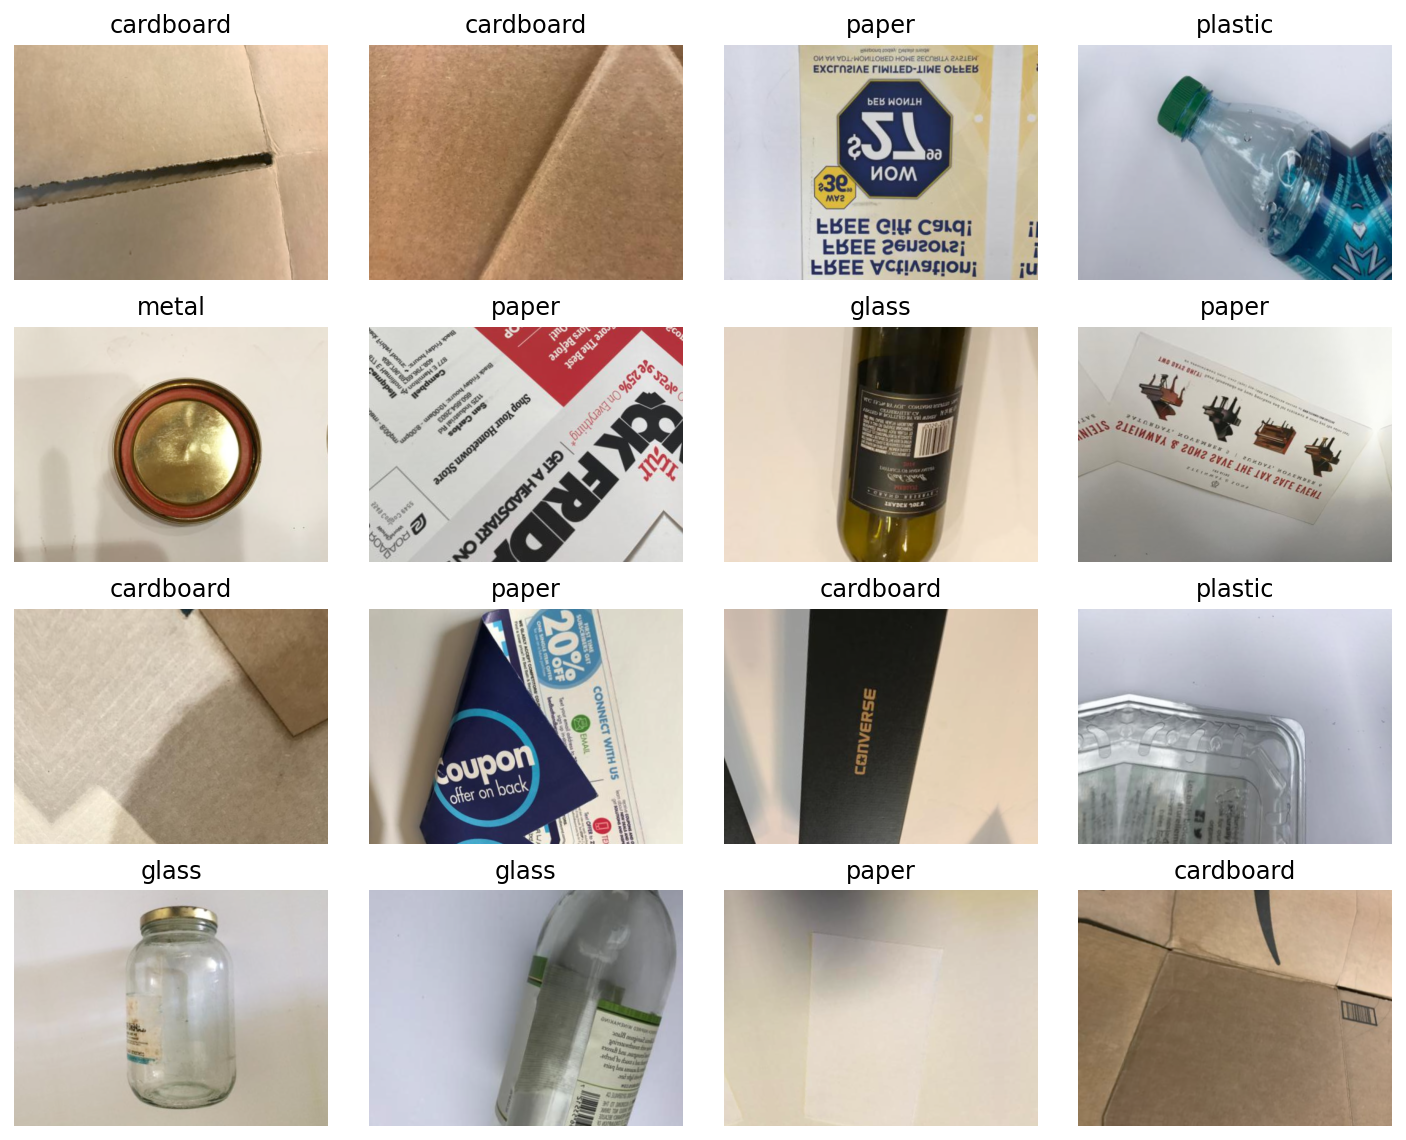

In [82]:
data.show_batch(rows=4,figsize=(10,8))

In [83]:
from fastai.callbacks import *

learn = cnn_learner(data,models.resnet34,metrics=[accuracy,error_rate],
                   callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

In [84]:
# learn.model

In [85]:
# learn.lr_find(start_lr=1e-6,end_lr=1e1)
# learn.recorder.plot(suggestion=True)

In [86]:
learn.fit_one_cycle(25,max_lr=3.31E-04)

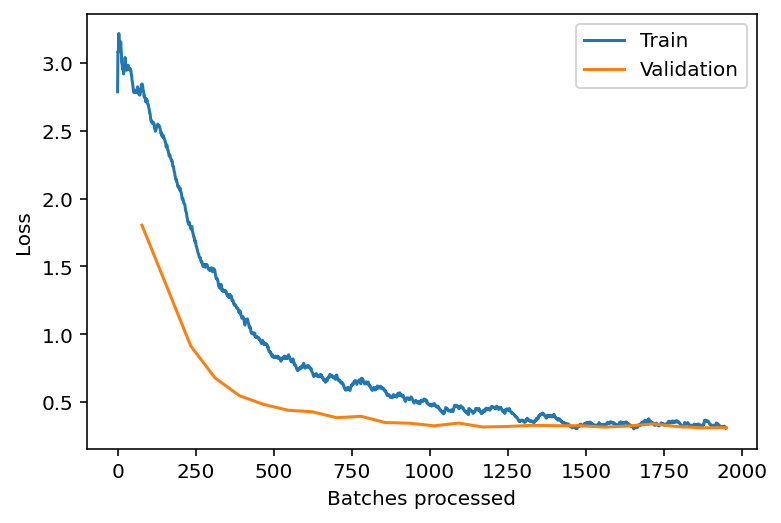

In [38]:
learn.recorder.plot_losses()

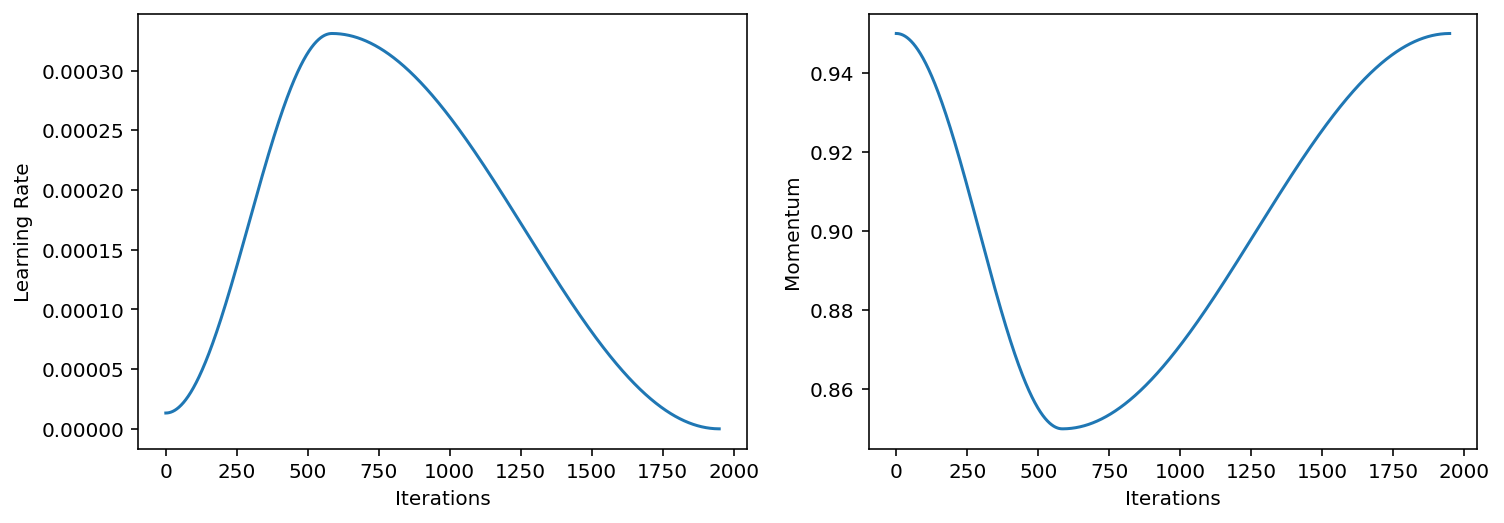

In [39]:
learn.recorder.plot_lr(show_moms=True)

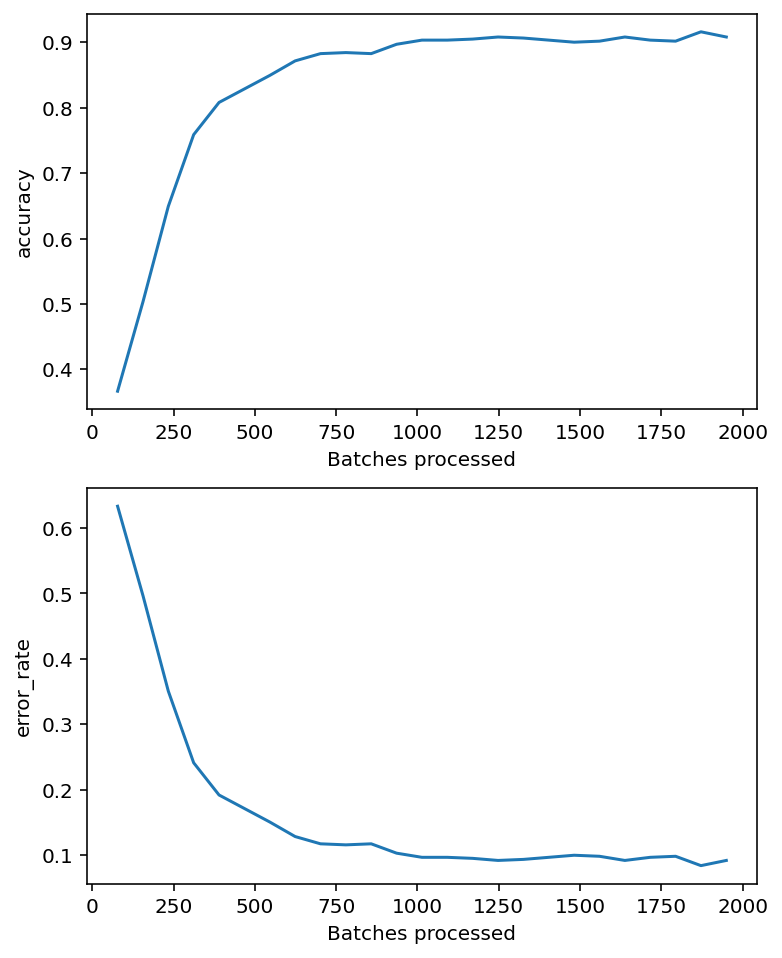

In [40]:
learn.recorder.plot_metrics()

In [41]:
# VIsualizing most incorrect images

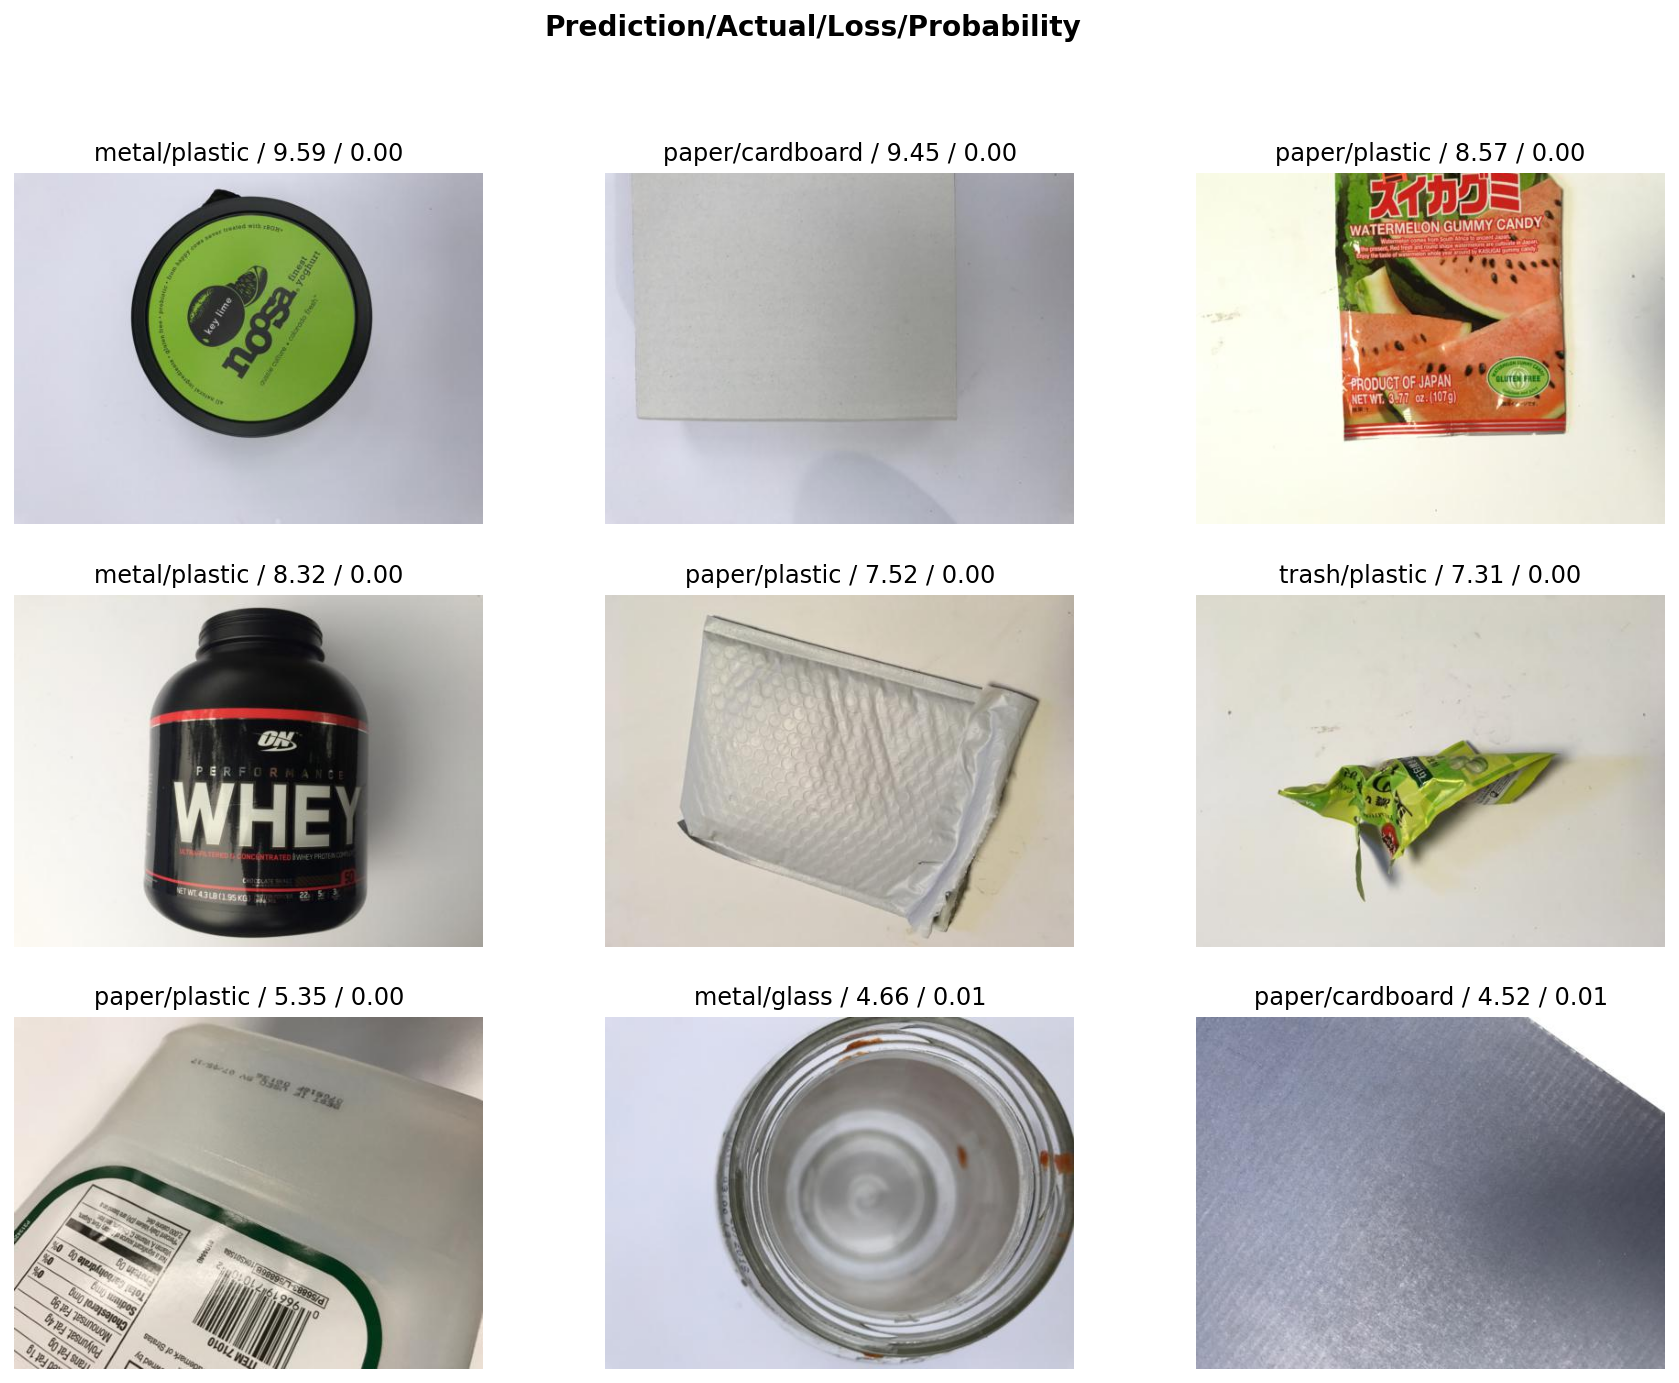

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

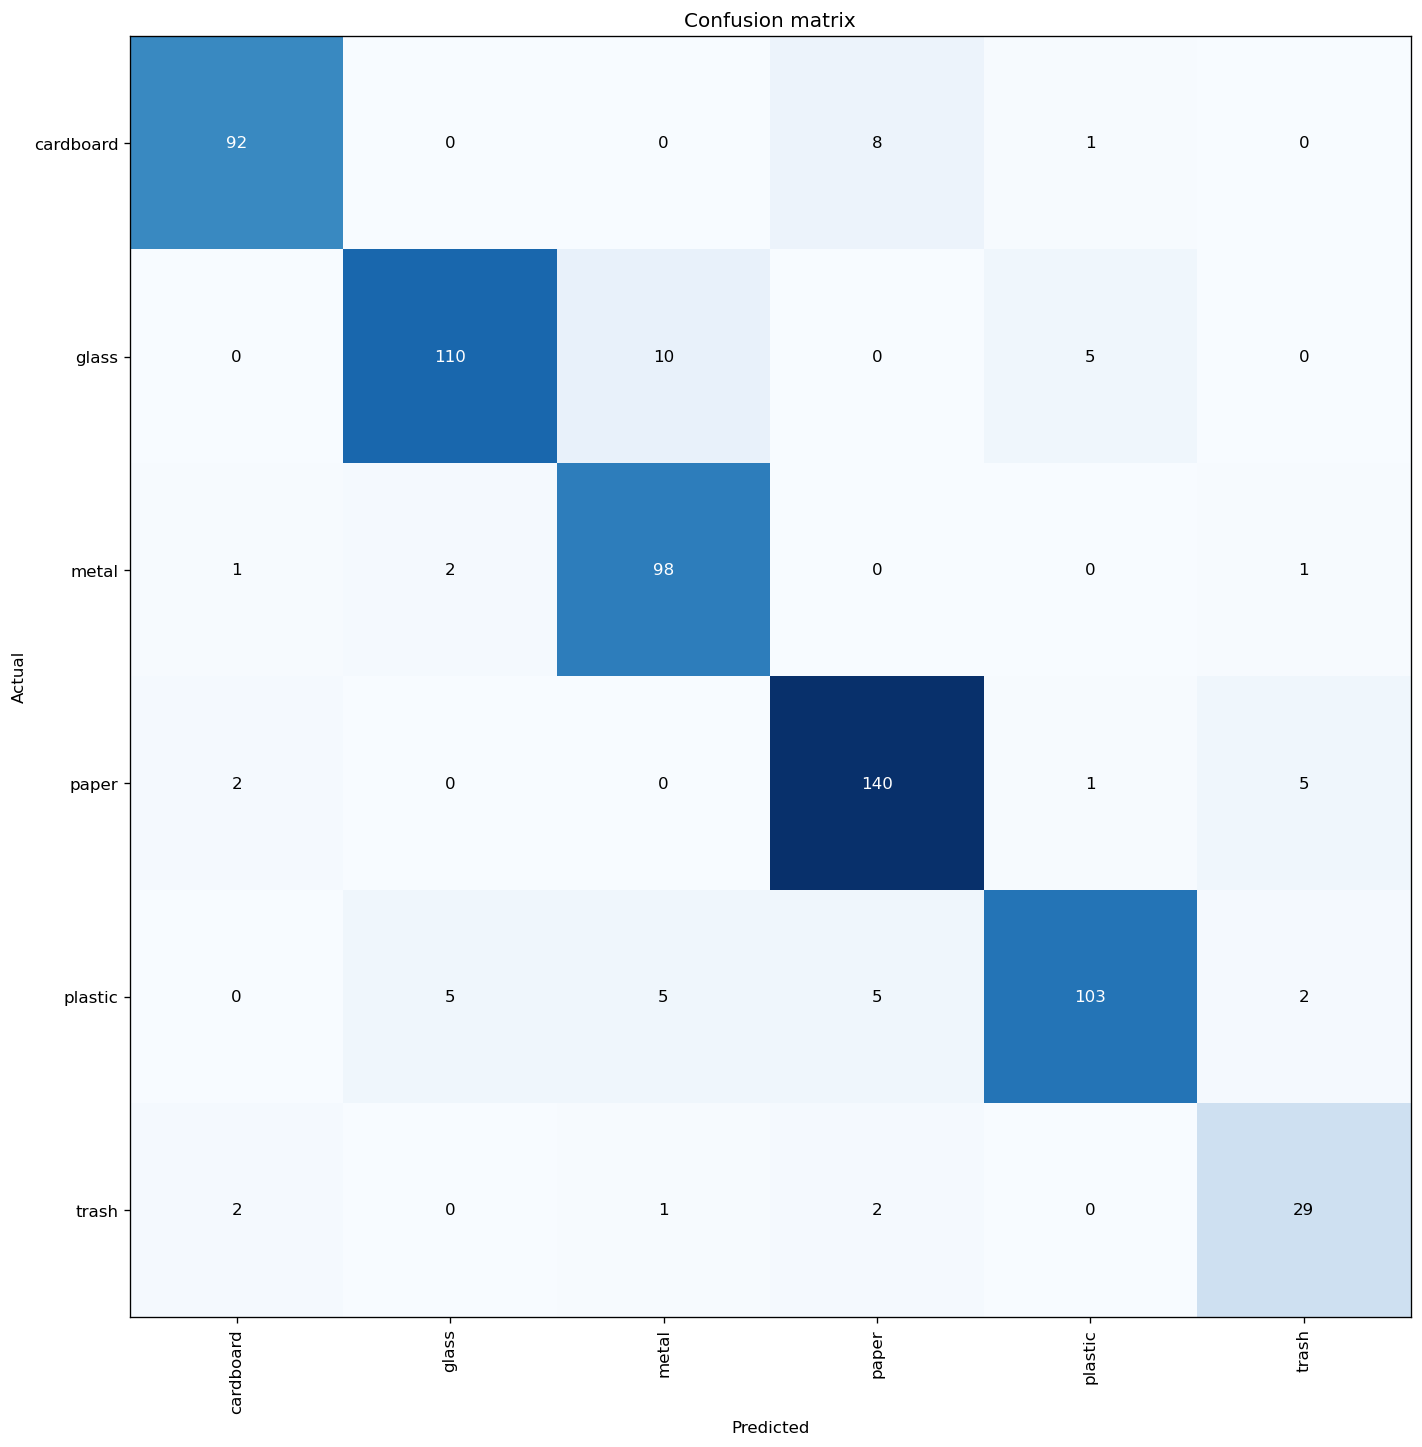

In [43]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=2)

[('glass', 'metal', 10),
 ('cardboard', 'paper', 8),
 ('glass', 'plastic', 5),
 ('paper', 'trash', 5),
 ('plastic', 'glass', 5),
 ('plastic', 'metal', 5),
 ('plastic', 'paper', 5),
 ('metal', 'glass', 2),
 ('paper', 'cardboard', 2),
 ('plastic', 'trash', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'paper', 2)]

In [45]:
# Make new predictions on test data

In [46]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [47]:
# preds

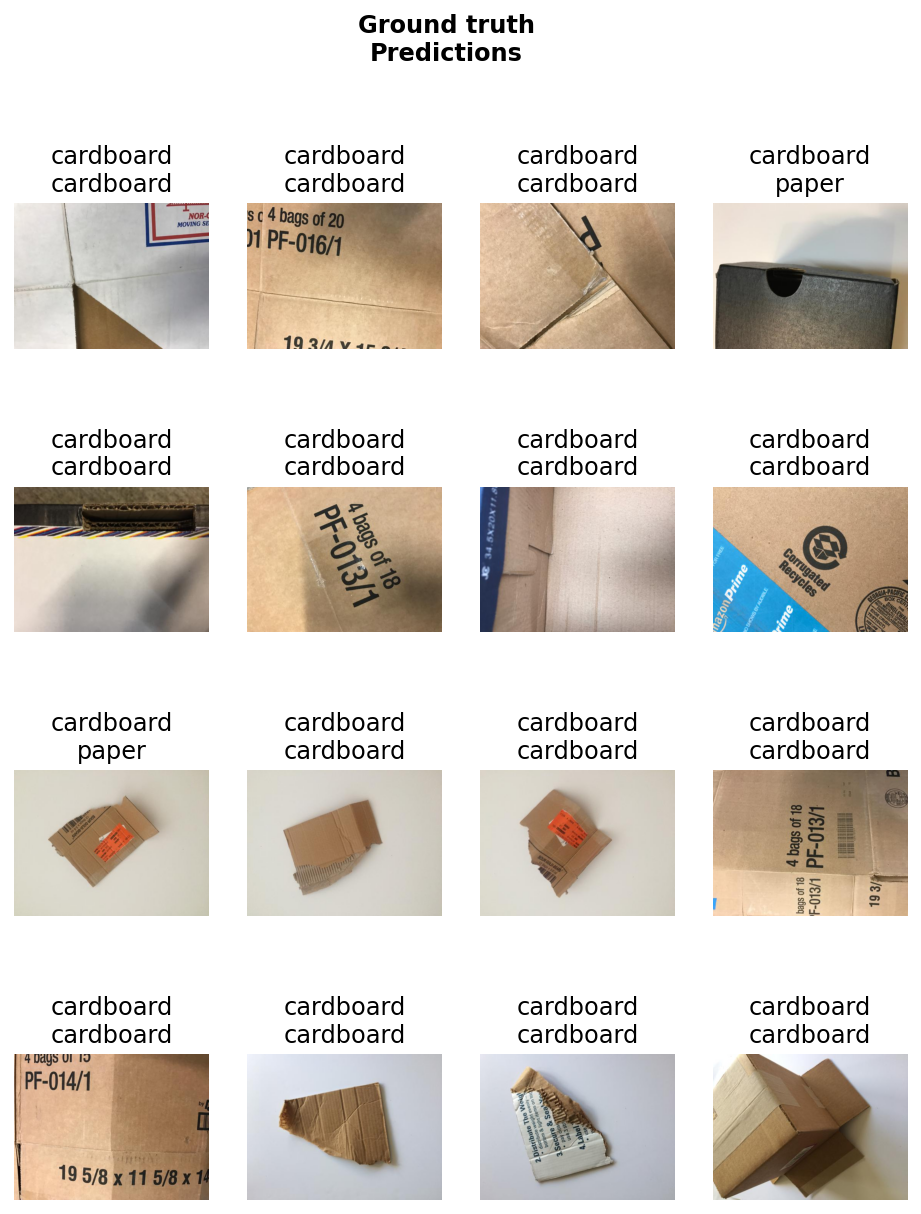

In [48]:
learn.show_results(ds_type=DatasetType.Valid, rows=10, figsize=(8,10))

# Note that the text number on the top is the ground truth, or the target label, the one in the 
# middle is the prediction, while the image number on the bottom is the image data itself.

In [49]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [50]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9991e-01, 1.6894e-06, 7.5051e-05, 1.0290e-05, 9.3258e-08, 6.4618e-06],
        [9.9993e-01, 6.6060e-08, 2.3024e-07, 1.0199e-06, 6.4076e-07, 6.5773e-05],
        [1.0000e+00, 3.2759e-08, 7.2518e-08, 3.3389e-09, 3.1557e-07, 2.8404e-07],
        ...,
        [1.2903e-02, 3.9462e-05, 2.8686e-05, 5.2806e-01, 2.6390e-04, 4.5871e-01],
        [1.2599e-04, 6.9387e-07, 6.9284e-08, 9.8316e-01, 4.1622e-08, 1.6714e-02],
        [3.7938e-01, 6.3990e-04, 6.3962e-03, 4.6228e-01, 1.2801e-04, 1.5118e-01]])

In [51]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [52]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
max_idxs

array([0, 0, 0, 0, ..., 4, 3, 3, 3], dtype=int64)

In [53]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [54]:
# yhat

In [55]:
# learn.data.test_ds[0][0]

In [56]:
def image_type(filename):
    
    if "cardboard" in filename:
        return 'cardboard'
    elif "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "trash" in filename:
        return 'trash'
    
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
#     y[i] = pattern.search(y[i]).group(1)
    true_type = image_type(y[i])
    y[i] = true_type

In [57]:
## predicted values
print(yhat[0:15])
## actual values
print(y[0:15])

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']
['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']


In [58]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 94   0   2   5   0   0]
 [  0 111   9   0   6   0]
 [  0   9  92   1   0   1]
 [  0   0   2 145   0   2]
 [  0   9   1   1 107   3]
 [  0   2   4   6   2  21]]


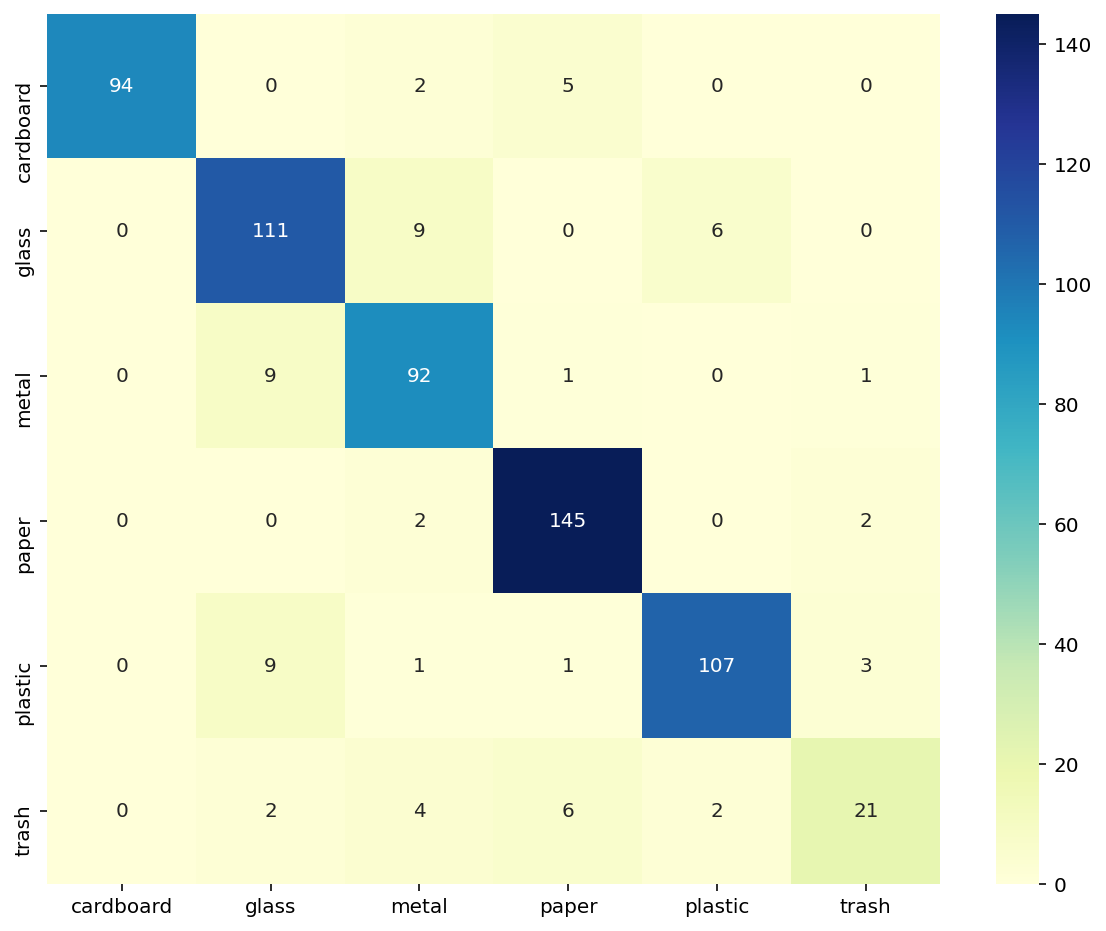

In [59]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

df_cm
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [60]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
            
accuracy = correct/sum(sum(cm))
accuracy

0.8976377952755905

In [61]:
learn.export('trained_model.pkl')

In [62]:
path = learn.path
path

WindowsPath('C:/Mun/Spring2020/Course_Study/9804 (ImageProcessingandApplications)/Project/Code/data')

In [63]:
model = load_learner(path, 'trained_model.pkl')

In [64]:
# def load_image(filename):
#     img = cv2.imread(os.path.join(predict_dir, filename))
# #     img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
# #     img = img /255
    
#     print(img)
#     a,b,c = learn.predict(img)
#     print(a) 
 

In [90]:
base_dir = 'data' 
predict_dir = os.path.join(base_dir, 'test')
predict_dir

IMAGE_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)

In [92]:
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]
# onlyfiles

In [ ]:
# path = predict_dir + "\paper25.jpg"
# img = cv2.imread(path)

# plt.imshow(img)
# plt.show()

# t = pil2tensor(img, dtype=np.float32) 
# im = Image(t)
# pred_class,pred_idx,outputs = learn.predict(im)
# print(pred_class)
# print(pred_idx)
# print(outputs)

tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0.])


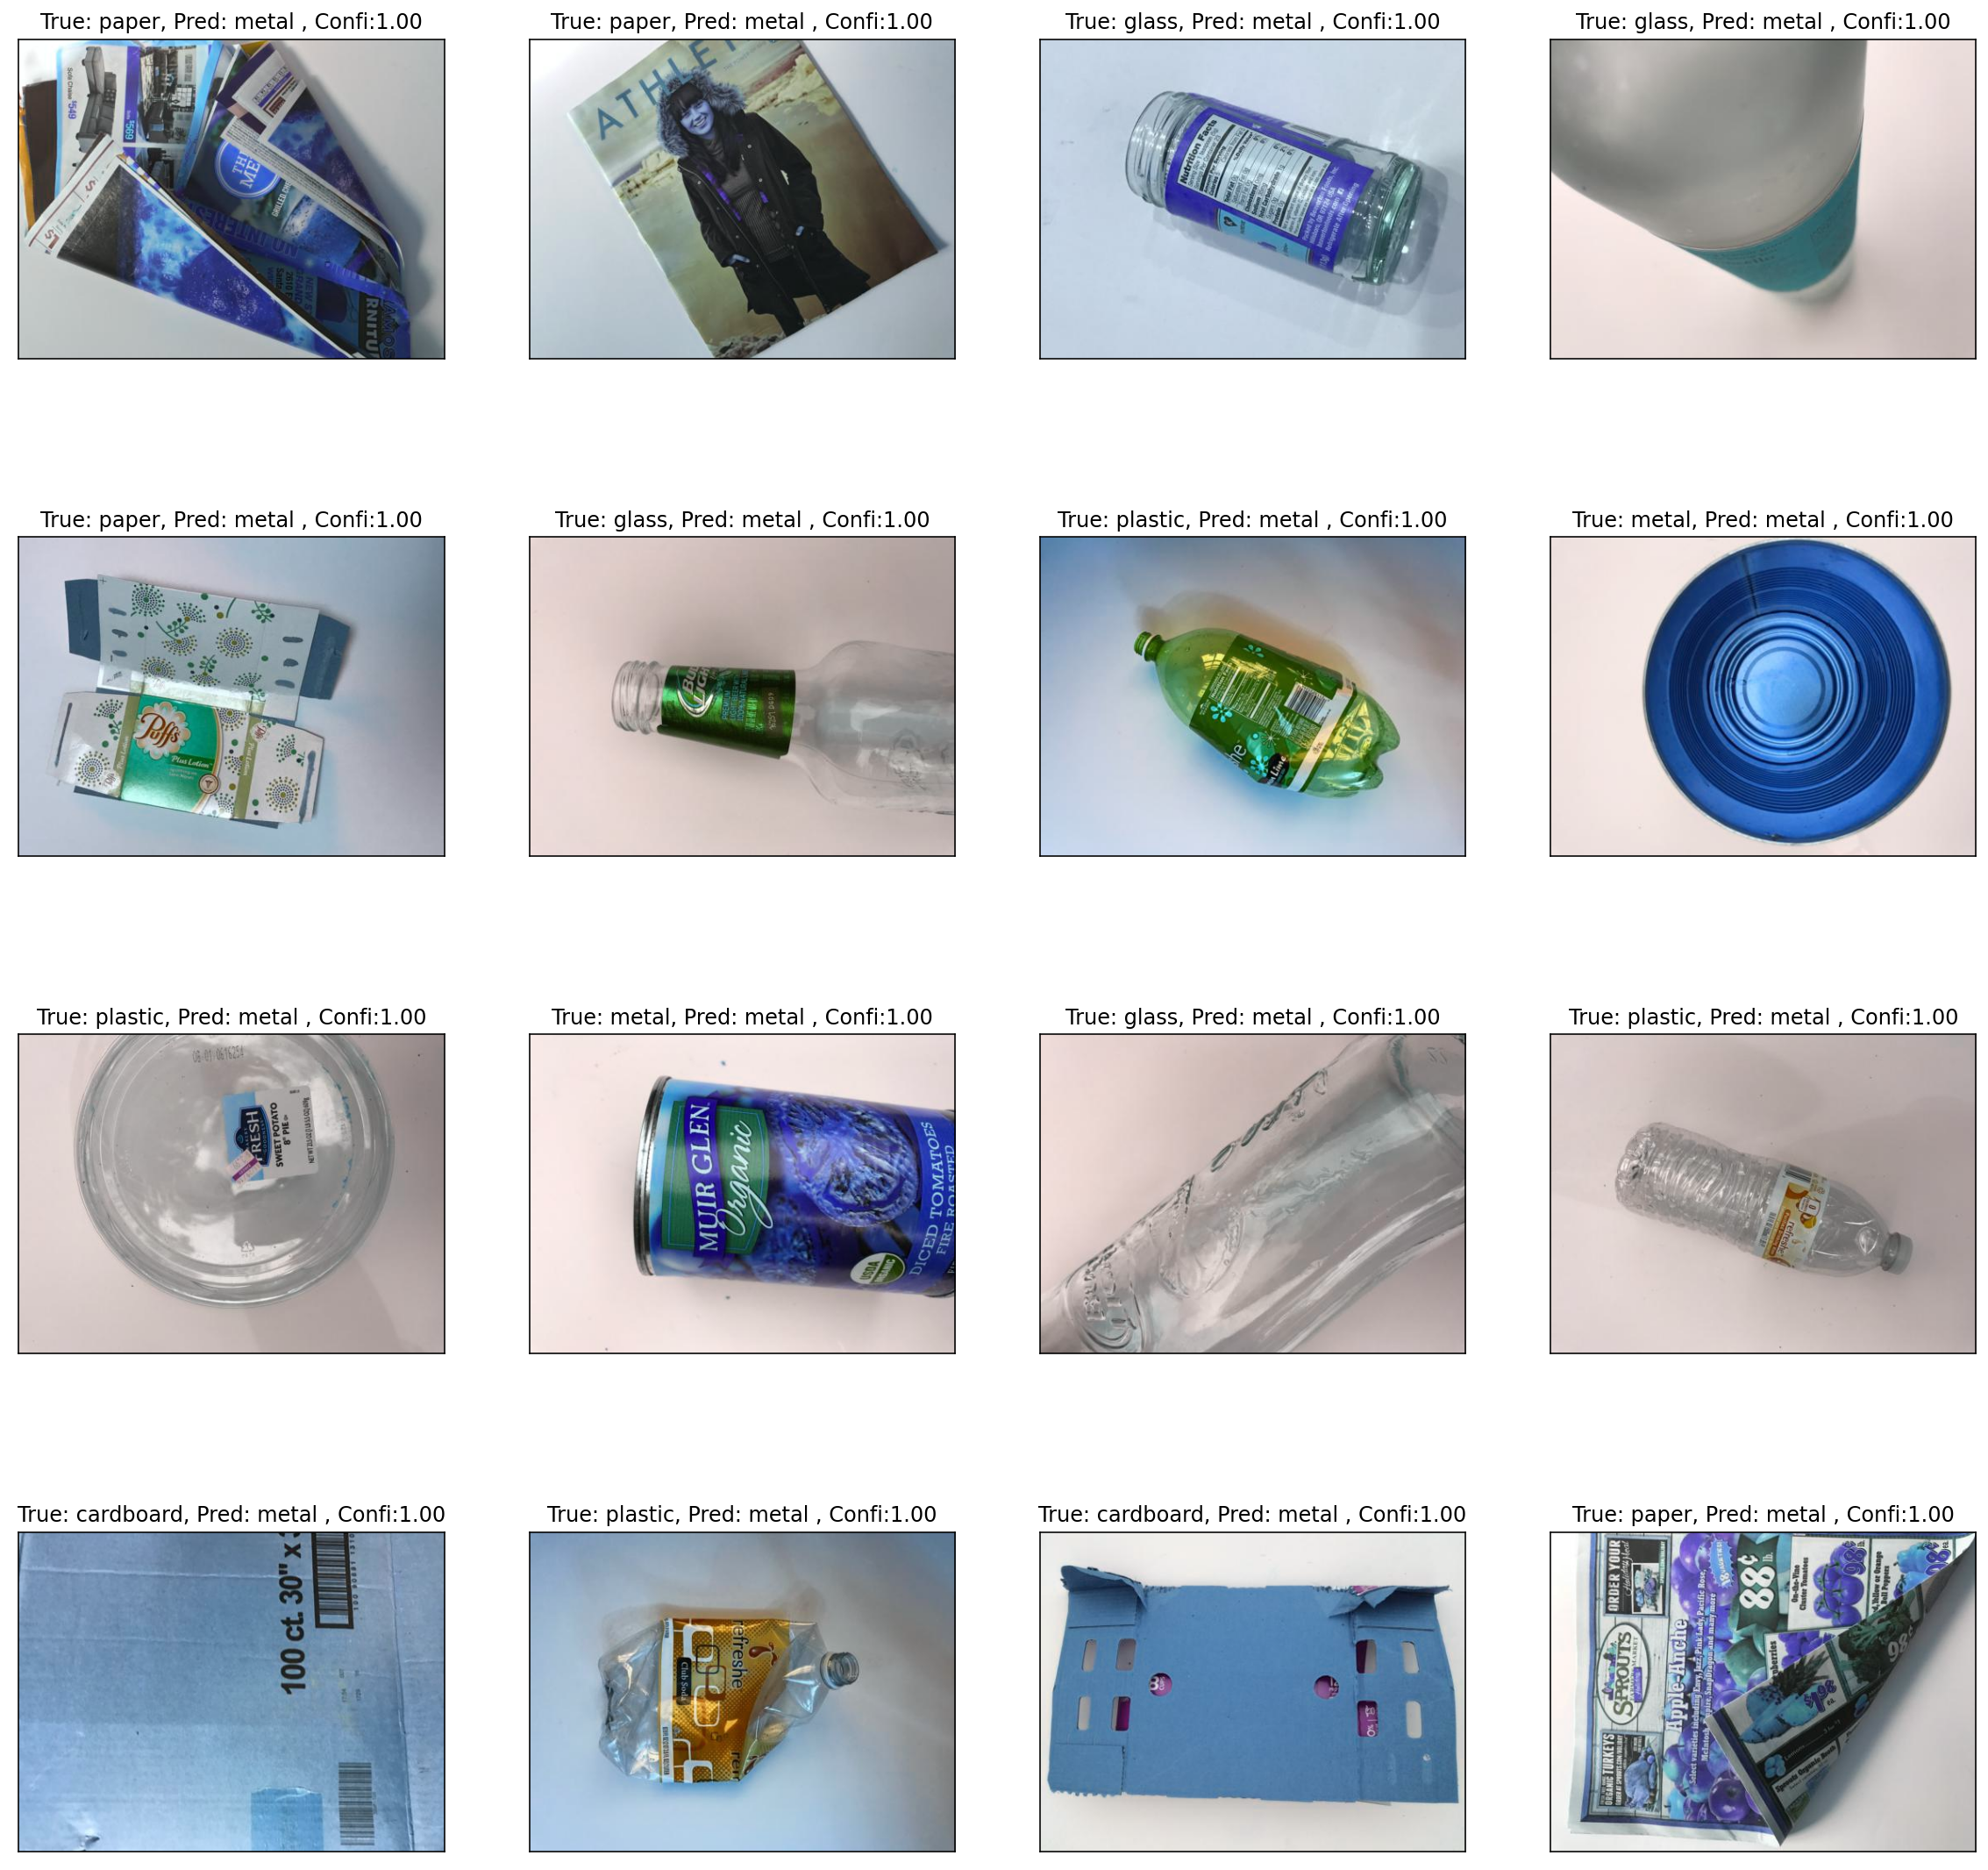

In [93]:
def predict(file_name):
    path = predict_dir + "\\" + file_name 
    img = cv2.imread(path)

    t = pil2tensor(img, dtype=np.float32) 
    im = Image(t)
    pred_class,pred_idx,outputs = model.predict(im)
    return pred_class,pred_idx,outputs,img


def plot_predicted_label_1(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 20))
    
    rs = np.random.choice(len(onlyfiles), nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        true_type = image_type(onlyfiles[i])
        prediction,pred_idx,outputs,img = predict(onlyfiles[i])
         
        print(outputs)
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,prediction,outputs[pred_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 4
num_cols = 4
plot_predicted_label_1(num_rows, num_cols,onlyfiles)
    